# Uber ride reviews

####***prepared by Nabil Affo***

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## The data

We used the [Uber Ride Review Dataset](https://www.kaggle.com/purvank/uber-rider-reviews-dataset) .The dataset contains uber ride reviews from 2014-2017. It has 1342 reviews organized in 3 columns: 
1.   ride_review : review of the ride
2.   ride_rating: the rating is from 1 to 5
3.   ride_sentiment: if the rating is above 3  it is a positive sentiment(1), otherwise it's a negative sentiment(0).



In [0]:
path = Path(base_dir + 'data/uber')
df = pd.read_csv(path/'Uber_Ride_Reviews.csv')
df.head()

,ride_review,ride_rating,sentiment
0,I completed running New York Marathon requeste...,1.0,0
1,My appointment time auto repairs required earl...,1.0,0
2,Whether I using Uber ride service Uber Eats or...,1.0,0
3,Why hard understand I trying retrieve Uber cab...,1.0,0
4,I South Beach FL I staying major hotel ordered...,1.0,0


Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them into numbers. This is done in two differents steps: ***tokenization*** and ***numericalization***. `TextDataBunch` does all of that behind the scenes .

#### Tokenization

It splits the raw sentences of the texts into words called tokens. We do this split of strings on spaces, but we consider other criteria such as punctuation, contractions of words, cleaning of HTML code...



#### Numericalization

Once we have extracted tokens from the texts, we convert them  into integers by creating a list of all the words used. We only keep the ones that appear at least twice and replace the ones that don't make the cut by the unknown token `UNK`. The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets.

#### With the data block API

We can use the data block API with NLP.

## Language model

In [0]:
bs=30

In [0]:
path = Path(base_dir + 'data/uber')
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/uber/Uber_Ride_Reviews.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/uber/Uber_Ride_Reviews.gsheet'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/uber/test')]

The reviews are in a training and test set. We'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what is the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [0]:
data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['test']) 
            .split_by_rand_pct(0.1)
            .label_for_lm() 
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,xxbos xxmaj you probably fine try switch user xxup id account xxunk phone number forever xxmaj uber respond online support requests phone number call i tried three times get resolve problem ignored email responses \n xxbos xxmaj they suddenly blocked account xxmaj will respond emails tell \n xxbos crappy company zero stars treating drivers poorly get wonder xxunk rates percent xxunk sooner later wo drivers come pick customers
1,in xxup mins xxup they xxup have xxup no xxup xxunk xxup and xxup they xxup need xxup to b xxup shut xxup down xxup they xxup also xxup have xxup no xxup xxunk xxup insurance xxup so xxup if xxup your xxup driver xxup gets xxup in xxup an xxup accident xxup you xxup will xxup not xxup be xxup covered xxup how xxup unsafe xxup that xxup company
2,customer details sold web xxmaj no phone number contact use xxunk gave star minus button \n xxbos i purchased xxmaj uber gift card amount son use xxmaj he tried redeem however xxmaj uber asked credit card xxmaj hence xxunk xxmaj uber gift card xxmaj in attempt satisfy xxmaj uber request i purchased another gift card thinking act xxunk xxmaj instead xxmaj uber app requested son provide credit card info
3,xxmaj then ask information xxmaj are stealing info xxunk phone \n xxbos xxmaj uber xxunk standard upfront charges pool rides per promo provided kms i booked cab xxmaj saturday pm i showing however per drop location i charged i really know i charged much top xxmaj uber driver customer care number i told i giving money shown started giving xxunk said started talking xxunk xxmaj if pay i able
4,fool xxunk number i screenshot quite smart enough respond auto text i sent number listed got reply i smell xxunk xxup xxunk smell xxup hell xxmaj by way i one free text message numbers choose i born came site since i write speak xxmaj uber xxmaj soon life xxup fool i wrong i think xxmaj you tell i get xxmaj uber xxmaj since trip never made i write review xxmaj


We put the learner object very easily with a model loaded with the pretrained weights.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


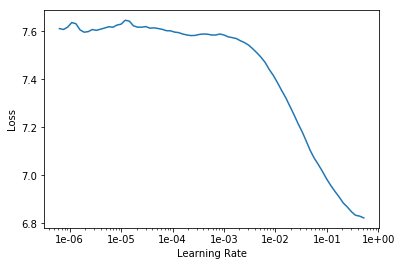

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.865604,5.031974,0.190556,00:04


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.597655,4.982333,0.195794,00:05
1,4.520119,4.936551,0.194206,00:05
2,4.369713,4.960112,0.188889,00:05
3,4.068884,5.045672,0.183254,00:05
4,3.665046,5.177329,0.177540,00:05
5,3.164816,5.437503,0.161270,00:05
6,2.675958,5.682334,0.153571,00:05
7,2.269920,5.820192,0.151587,00:05
8,1.999234,5.911433,0.147778,00:05
9,1.843849,5.937149,0.148175,00:06


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Uber is"
N_WORDS = 10
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Uber is common today They mind low prices low price taxis
Uber is good making money It always worth good business worth


We save the model, but also its encoder which is responsible for creating and updating the hidden state.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

We want to know whehter a review is positive (1) or negative (0). We create a new data object and we save it.

In [0]:
 data_clas = (TextList.from_csv(path, 'Uber_Ride_Reviews.csv', cols=0,vocab=data_lm.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols=2)
             .databunch())

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj danielle xxmaj sep xxup pdt i want personal info site i believe identity stolen xxmaj uber employee well fraud committed xxmaj if true employee used name xxup ssn xxup dob xxup dl apply credit accounts xxmaj thus far person applied credit cards xxmaj xxunk xxmaj finger xxmaj xxunk xxmaj pay xxmaj xxunk i found news today a person high authority xxup uber needs find xxmaj uber employee stolen,0
xxbos xxup uber xxup is xxup thee xxup most xxup xxunk xxup xxunk xxup company xxup in xxup xxunk xxup it xxup xxunk xxup even xxup be xxup in xxup arizona xxup if xxup xxunk xxup going xxup to xxup run xxup it xxup the xxup way xxup they xxup do xxup here xxup in xxup xxunk xxup the xxup only xxup fares xxup my xxup so xxup ever xxup,0
xxbos xxmaj this follow previous review xxmaj in xxmaj dallas xxmaj uber increased cut total take xxunk cost ride xxmaj now xxmaj uber charges cents per ride dollar cents fee per ride take top percent left xxmaj thus minimum ride ride miles xxunk xxmaj uber charge xxmaj the driver gets gross dollars cents xxmaj uber takes dollars cents xxmaj if xxunk enough give ride xxup xxunk student order take fast,0
xxbos xxmaj when i first began operating legal public xxunk transportation company serving island community xxmaj xxunk i desperate new business xxmaj uber find actual insured state county xxup licensed transportation company serve airport xxmaj after heavily xxunk put xxup bmw service airport assured decent compensation i took offer one xxunk customers ready xxup now pay fares i fool xxmaj uber available popular airport serving xxunk travelers xxup us legally,0
xxbos xxmaj uber one shady unethical companies ever created i stopped driving year ago decided try ubereats delivery person i figured better i drive people boy i wrong xxmaj first take every delivery xxmaj then enough delivery drivers i noticed i driving mins reach restaurant compensated pick order delivered location may mins away xxmaj giving driver whopping delivery i also gone pick orders arrive restaurant find order cancelled xxmaj uber,0


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


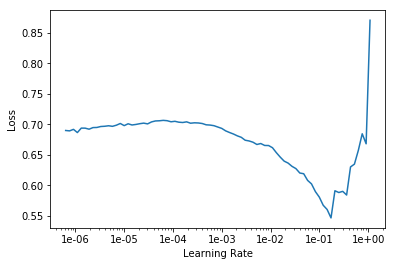

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.474510,0.322776,0.884328,00:03


In [0]:
learn.save('first')

In [0]:
learn.load('first');

We freeze up to the last layers and train more.

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.371350,0.307332,0.891791,00:04


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.355858,0.288031,0.888060,00:06


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.297812,0.281514,0.899254,00:07
1,0.273468,0.282237,0.899254,00:07


We test our model .

In [0]:
learn.predict("I disliked the ride")

(Category 0, tensor(0), tensor([0.8598, 0.1402]))